# Summary
In this part, we try to again train a regressor which predicts the two moons logprob of a coordinate, but we also train a INN to first transform the x coordinates into latent z coordinates.  First, a regressor is trained on the latent values of a pretrained INN, then we employ a training scheme which alternatingly optimizes a new INN and then the regressor. \
One could argue, that with the alternating training scheme it makes sense to only start training the regressor once our INN has converged to some degree. But as we try to implement a single model which learns both the latent transformation and the logprobs simultaneously, we stick to training the INN and the regressor in parallel. \
We train the INN with the INN loss and track the MMD value of its generated samples and samples from our KDE. We also use Optuna for hyperparameter optimization again, and check the variance of the models performance by training it multiple times.\
# Takeaway
Training the regressor on the latents is possible and leads to similar result, but more attention needs to be paid to model and training hyperparameters and training takes a lot longer.
# Accuracy
KL divergence with KDE distribution:\
**Regressor with pre-trained INN: 3e-5**\
**Regressor jointly trained with INN: 4e-5**\
(These might not be comparable to models which are not trained with KDE ground-truth)\
**MMD of INN-generated samples with true data: 3,2e-3**

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import tqdm
import optuna
from optuna.trial import TrialState
import numpy as np
import copy

import distributions as d
import evaluation as e
import models as m

c:\Users\Fritz\anaconda3\envs\analyzing_invs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
n_dim = 2
device = "cpu"

# Parameters for INN Training

In [3]:
inn_batchsize = 100
hidden_dim = 20
n_blocks = 32
inn_epochs = 4000
inn_lr = 0.0002
subnet_hidden_layers = 2

100%|██████████| 4000/4000 [05:00<00:00, 13.32it/s]


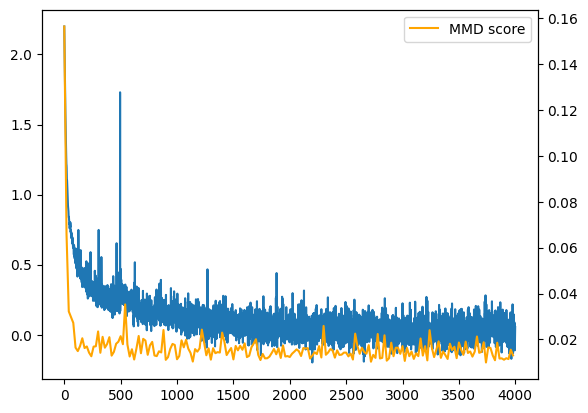

In [7]:
inn = m.realNVP(n_dim, hidden_dim, n_blocks, subnet_hidden_layers=subnet_hidden_layers)
inn, metrics, model_snapshots = m.train_inn(inn, 
                                          batchsize=inn_batchsize, 
                                          epochs=inn_epochs, 
                                          lr=inn_lr, 
                                          calculate_mmd=True)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(metrics["inn_loss"], label="INN Loss")
ax2.plot(metrics["mmd"][0], metrics["mmd"][1], label="MMD score", color="orange")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


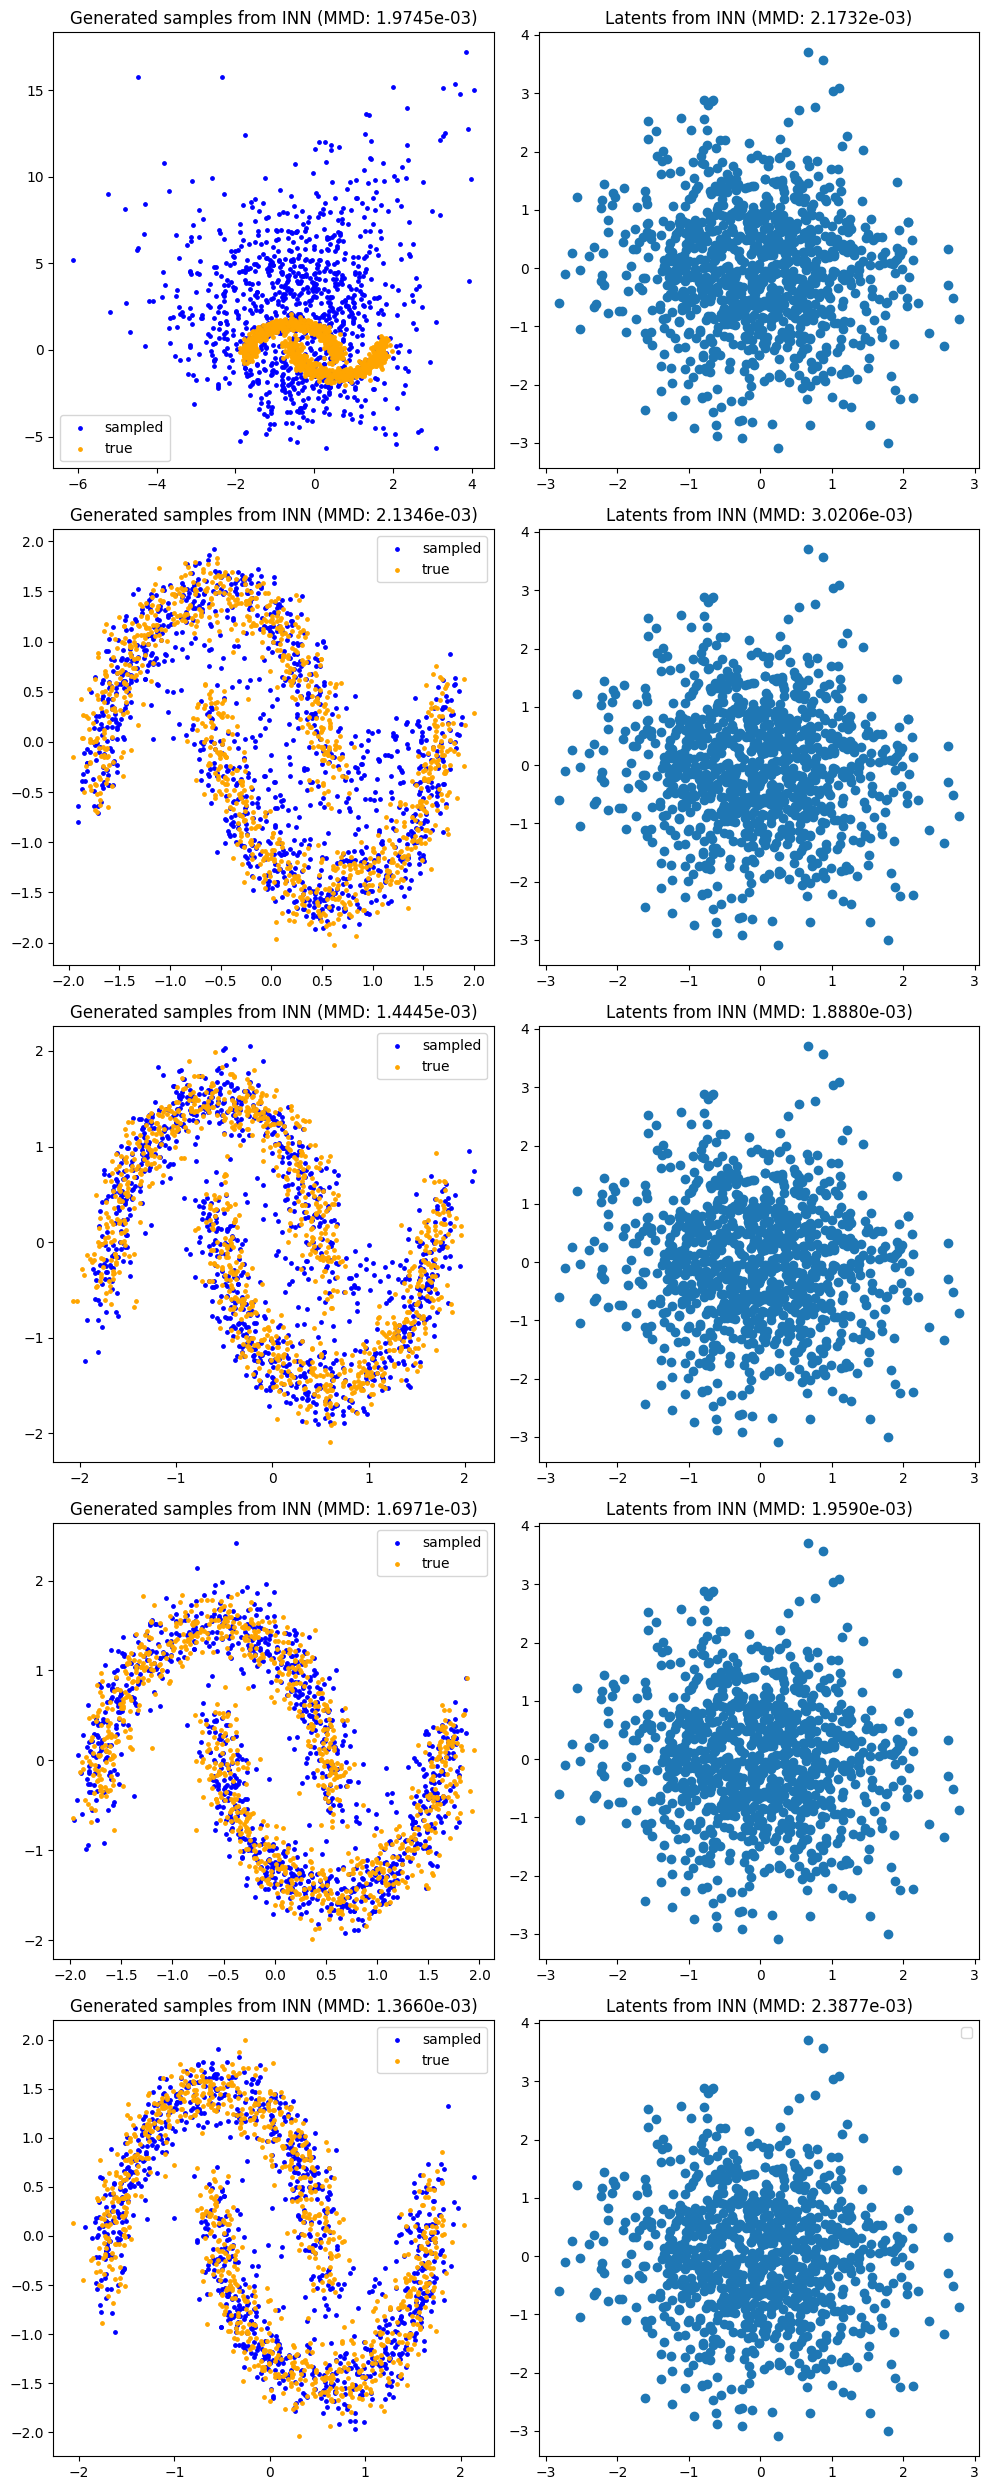

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(10, 25))

x, _ = make_moons(1000, noise=0.1)
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.Tensor(x_normalized)

for i in range(5):
    e.plot_inn_samples(model_snapshots[i*40], show_true=True, axs=axs[i][0])
    x_sample = inn(torch.randn((1000, 2)), rev=True)
    mmd_samples = e.mmd_inverse_multi_quadratic(x, x_sample)
    axs[i][0].set_title(f"Generated samples from INN (MMD: {mmd_samples:.4e})")

    z, _ = inn(x)
    mmd_latents = e.mmd_inverse_multi_quadratic(z, torch.randn((1000, 2)))
    z = z.detach().numpy()
    axs[i][1].scatter(z[:,0], z[:,1])
    axs[i][1].set_title(f"Latents from INN (MMD: {mmd_latents:.4e})")

plt.legend()
plt.tight_layout()
plt.show()


# Functions for training regressor model

In [10]:
def train_regressor_with_inn(model, encoder, epochs=1000, batchsize=1000, trial=None, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    moons_dist = d.moons_distribution()
    loss_history = []
    metrics = {}

    for epoch in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        
        x, _ = make_moons(batchsize, noise=0.1)
        scaler = StandardScaler()
        x_normalized = scaler.fit_transform(x)
        x = torch.Tensor(x_normalized)
        z, _ = encoder(x)
        
        pred = model(z).squeeze()
        logprobs = moons_dist.score_samples(x)
        logprobs = torch.Tensor(logprobs).float().to(device)   
        
        loss = e.generalized_kl(pred, logprobs)
        loss.mean().backward()
        
        optimizer.step()
        loss_history.append(loss.mean().item())
        
        if trial is not None: trial.report(loss.mean().item(), epoch)
    metrics["kld_loss"] = loss_history
    return model, metrics

# Regressor Parameters

In [11]:
regressor_hidden = 275
regressor_layers = 10
regressor_lr = 0.000117
regressor_batchsize = 635
regressor_epochs = 6000

# Training Regressor on latent variables from INN

100%|██████████| 6000/6000 [19:41<00:00,  5.08it/s]


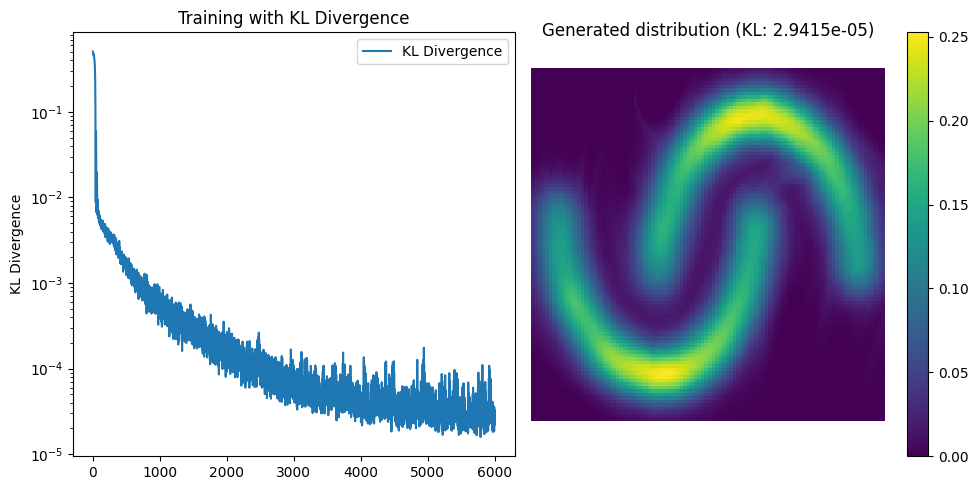

In [51]:
regressor = m.make_regressor(n_dim=n_dim, 
                           hidden_dim=regressor_hidden, 
                           n_layers=regressor_layers)
regressor, metrics = train_regressor_with_inn(regressor, 
                                              inn, 
                                              epochs=regressor_epochs, 
                                              batchsize=regressor_batchsize, 
                                              lr=regressor_lr)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

# Plot KL Divergence during training
axs[0].plot(metrics["kld_loss"], label="KL Divergence")
axs[0].set_ylabel("KL Divergence")
axs[0].set_yscale("log")
axs[0].set_title("Training with KL Divergence")

# Contour plot of predicted distribution and KL divergence with KDE-GT
e.contour_plot(regressor, ax=axs[1], encoder=inn)
axs[1].set_title(f"Generated distribution (KL: {e.kldiv(regressor, encoder=inn).mean().item():.4e})")

axs[0].legend()
plt.tight_layout()
plt.show()

# Training regressor and INN alternatingly with two separate loss functions

In [12]:
def train_regressor_with_untrained_inn(regressor, encoder, epochs=1000, 
                                       batchsize=1000, trial=None, inn_lr=0.001,
                                       regressor_lr=0.001, mmd_beta=0.1):
    inn_optimizer = torch.optim.Adam(encoder.parameters(), lr=inn_lr)
    regressor_optimizer = torch.optim.Adam(regressor.parameters(), lr=regressor_lr)

    moons_dist = d.moons_distribution()
    inn_loss_history = []
    metrics = {"inn_loss": [],
               "regressor_loss": [],
               "mmd": []}

    for epoch in tqdm.tqdm(range(epochs)):
        inn_optimizer.zero_grad()
        regressor_optimizer.zero_grad()
        
        x, _ = make_moons(batchsize, noise=0.1)
        scaler = StandardScaler()
        x_normalized = scaler.fit_transform(x)
        x = torch.Tensor(x_normalized)
        z, ljd = encoder(x)
        
        normal = torch.randn_like(z)
        mmd = e.mmd_inverse_multi_quadratic(z, normal)
        metrics["mmd"].append(mmd.item())

        if epoch%2==0:#
            inn_loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
            inn_loss += mmd_beta*mmd
            inn_loss.backward(retain_graph=True)
            
            inn_optimizer.step()
            metrics["inn_loss"].append(inn_loss.mean().item())
        
        if epoch%2==1:
            pred = regressor(z).squeeze()
            logprobs = moons_dist.score_samples(x)
            logprobs = torch.Tensor(logprobs).float().to(device)   
            
            regressor_loss = e.generalized_kl(pred, logprobs)
            regressor_loss.mean().backward()
            
            regressor_optimizer.step()
            metrics["regressor_loss"].append(regressor_loss.mean().item())
        
        if trial is not None: trial.report(regressor_loss.item(), epoch)
    return regressor, encoder, metrics

100%|██████████| 6000/6000 [15:07<00:00,  6.62it/s]


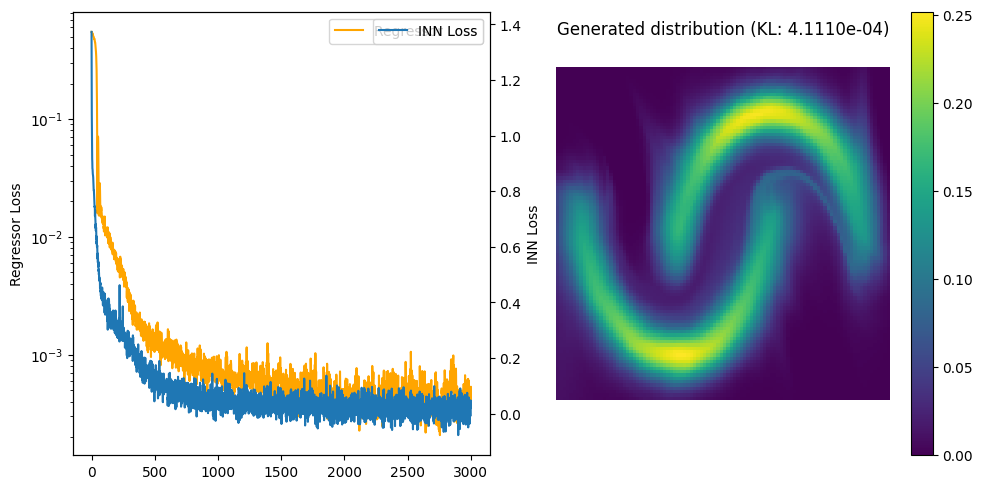

In [13]:
untrained_inn = m.realNVP(n_dim, hidden_dim, n_blocks)
regressor = m.make_regressor(n_dim=n_dim, 
                           hidden_dim=regressor_hidden, 
                           n_layers=regressor_layers)
regressor, untrained_inn, metrics = train_regressor_with_untrained_inn(regressor=regressor,
                                                                       encoder=untrained_inn,
                                                                       batchsize=regressor_batchsize,
                                                                       epochs=6000,
                                                                       regressor_lr=regressor_lr,
                                                                       inn_lr=inn_lr)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
ax2 = axs[0].twinx()

axs[0].plot(metrics["regressor_loss"], label="Regressor Loss", color="orange")
axs[0].set_ylabel("Regressor Loss")
axs[0].set_yscale("log")
axs[0].legend()

ax2.plot(metrics["inn_loss"], label="INN Loss")
ax2.set_ylabel("INN Loss")
ax2.legend(loc=0)

e.contour_plot(regressor, ax=axs[1], encoder=untrained_inn)
axs[1].set_title(f"Generated distribution (KL: {e.kldiv(regressor, encoder=untrained_inn).mean().item():.4e})")

plt.tight_layout()
plt.show()

# Test variance of quality

In [13]:
alternating_training_kl_values = []
for i in range(5):
    untrained_inn = m.realNVP(n_dim, hidden_dim, n_blocks)
    regressor = m.make_regressor(n_dim=n_dim, 
                            hidden_dim=regressor_hidden, 
                            n_layers=regressor_layers)
    regressor, untrained_inn, _ = train_regressor_with_untrained_inn(regressor=regressor,
                                                                        encoder=untrained_inn,
                                                                        epochs=1000)
    alternating_training_kl_values.append(e.kldiv(regressor, encoder=untrained_inn).mean().item())
    
pretrained_inn_kl_values = []
for i in range(5):
    regressor = m.make_regressor(n_dim=n_dim, 
                           hidden_dim=regressor_hidden, 
                           n_layers=regressor_layers)
    regressor, _ = train_regressor_with_inn(regressor, 
                                            inn, 
                                            epochs=1000, 
                                            batchsize=1000, 
                                            lr=0.001)
    pretrained_inn_kl_values.append(e.kldiv(regressor, encoder=inn).mean().item())
    
print(f"Mean of KL Div. of alternatingly trained model: {np.mean(alternating_training_kl_values):.4e}")
print(f"Stddiv of KL Div. of alternatingly trained model: {np.std(alternating_training_kl_values):.4e}")
print(f"Mean of KL Div. of model with pretrained INN: {np.mean(pretrained_inn_kl_values):.4e}")
print(f"Stddiv of KL Div. of model with pretrained INN: {np.std(pretrained_inn_kl_values):.4e}")    

100%|██████████| 1000/1000 [02:38<00:00,  6.31it/s]

Mean of KL Div. of alternatingly trained model: 1.1402e-03
Stddiv of KL Div. of alternatingly trained model: 5.2784e-04
Mean of KL Div. of model with pretrained INN: 5.2937e-04
Stddiv of KL Div. of model with pretrained INN: 1.2284e-04


# Test MMD of generated samples

Text(0.5, 1.0, 'Generated samples from INN (MMD: 1.6865e-03)')

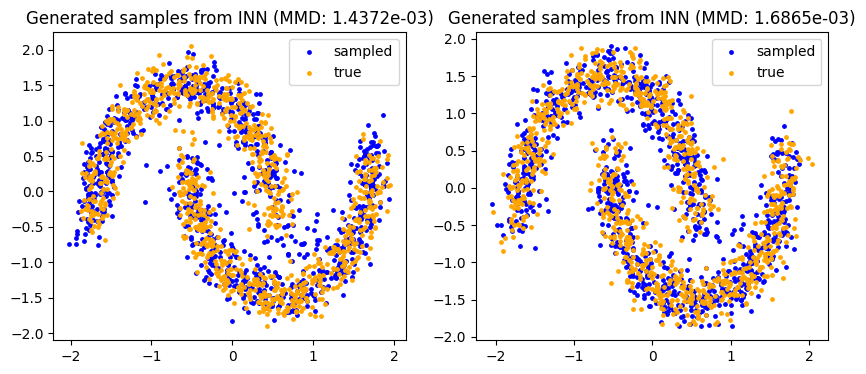

In [14]:
x, _ = make_moons(1000, noise=0.1)
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x = torch.Tensor(x_normalized)

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flatten()

e.plot_inn_samples(inn, show_true=True, axs=axs[0])
samples_pretrained = inn(torch.randn((1000, 2)), rev=True)
mmd_pretrained = e.mmd_inverse_multi_quadratic(x, samples_pretrained)
axs[0].set_title(f"Generated samples from INN (MMD: {mmd_pretrained:.4e})")

e.plot_inn_samples(untrained_inn, show_true=True, axs=axs[1])
samples_untrained = untrained_inn(torch.randn((1000, 2)), rev=True)
mmd_untrained = e.mmd_inverse_multi_quadratic(x, samples_untrained)
axs[1].set_title(f"Generated samples from INN (MMD: {mmd_untrained:.4e})")

plt.tight_layout()
plt.show()

# Optuna Optimization for INN Training

In [14]:
def define_model(trial):
  hidden_dim = trial.suggest_int("hidden_dim", 4, 100)
  n_blocks = trial.suggest_int("n_blocks", 5, 40)
  return m.realNVP(n_dim, hidden_dim, n_blocks)

def inn_objective(trial):
  model = define_model(trial).to(device)

  lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
  batchsize = trial.suggest_int("batchsize", 1, 500)

  _, metrics, _ = m.train_inn(model, batchsize=batchsize, epochs=2500, 
                         lr=lr, calculate_mmd=True)
  loss = np.mean(metrics["mmd"][1][-10:])
  return loss

def run_study(study, objective, n_trials=30):
  study.optimize(objective, n_trials=n_trials, timeout=None)

  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

  print("Study statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
    
  fig = optuna.visualization.plot_param_importances(study)
  fig.show()

In [15]:
inn_study = optuna.create_study(direction="minimize")
run_study(inn_study, inn_objective)

[I 2024-08-01 22:52:44,888] A new study created in memory with name: no-name-edb0254c-de53-47ab-9d51-fc4412d9cca7
100%|██████████| 2500/2500 [10:15<00:00,  4.06it/s]
[I 2024-08-01 23:03:00,349] Trial 0 finished with value: 0.00397716760635376 and parameters: {'hidden_dim': 76, 'n_blocks': 32, 'lr': 4.666442761879104e-05, 'batchsize': 357}. Best is trial 0 with value: 0.00397716760635376.
100%|██████████| 2500/2500 [03:00<00:00, 13.84it/s]
[I 2024-08-01 23:06:01,076] Trial 1 finished with value: 0.004759842157363891 and parameters: {'hidden_dim': 92, 'n_blocks': 5, 'lr': 0.00012746415363488195, 'batchsize': 375}. Best is trial 0 with value: 0.00397716760635376.
100%|██████████| 2500/2500 [07:37<00:00,  5.46it/s]
[I 2024-08-01 23:13:39,038] Trial 2 finished with value: 0.023140931129455568 and parameters: {'hidden_dim': 65, 'n_blocks': 36, 'lr': 0.0027840771063397285, 'batchsize': 147}. Best is trial 0 with value: 0.00397716760635376.
100%|██████████| 2500/2500 [06:38<00:00,  6.27it/s]
[

KeyboardInterrupt: 

# Optuna Optimization for Regressor

In [17]:
regressor_hidden = 150
regressor_layers = 3
regressor_lr = 0.001
regressor_batchsize = 500
regressor_epochs = 2000

def define_regressor(trial):
  hidden_dim = trial.suggest_int("hidden_dim", 4, 300)
  n_layers = trial.suggest_int("n_layers", 1, 10)
  return m.make_regressor(n_dim=n_dim, 
                        hidden_dim=hidden_dim, 
                        n_layers=n_layers)

def regressor_objective(trial):
  model = define_regressor(trial).to(device)

  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  batchsize = trial.suggest_int("batchsize", 1, 700)

  _, metrics = train_regressor_with_inn(regressor, 
                                        inn, 
                                        epochs=1000, 
                                        batchsize=batchsize, 
                                        lr=lr) 
  
  loss = np.mean(metrics["kld_loss"][-20:])
  return loss

def run_regressor_study(study, objective, n_trials=30):
  study.optimize(objective, n_trials=n_trials, timeout=None)

  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

  print("Study statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
    
  fig = optuna.visualization.plot_param_importances(study)
  fig.show()

In [18]:
regressor_study = optuna.create_study(direction="minimize")
run_regressor_study(regressor_study, regressor_objective)

[I 2024-07-31 18:07:31,727] A new study created in memory with name: no-name-46d4b9cd-75f4-4942-bf9a-d217784ed14a
100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]
[I 2024-07-31 18:09:38,631] Trial 0 finished with value: 0.00027535740882740357 and parameters: {'hidden_dim': 98, 'n_layers': 1, 'lr': 0.0009251145798478587, 'batchsize': 528}. Best is trial 0 with value: 0.00027535740882740357.
100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]
[I 2024-07-31 18:10:57,113] Trial 1 finished with value: 0.00031073614591150547 and parameters: {'hidden_dim': 155, 'n_layers': 1, 'lr': 1.5624188427150173e-05, 'batchsize': 278}. Best is trial 0 with value: 0.00027535740882740357.
100%|██████████| 1000/1000 [02:01<00:00,  8.23it/s]
[I 2024-07-31 18:12:58,588] Trial 2 finished with value: 0.00018021627438429276 and parameters: {'hidden_dim': 41, 'n_layers': 3, 'lr': 0.01566474148906201, 'batchsize': 568}. Best is trial 2 with value: 0.00018021627438429276.
100%|██████████| 1000/1000 [01:32<00:00,

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  30
Best trial:
  Value:  4.8784688988234845e-05
  Params: 
    hidden_dim: 275
    n_layers: 10
    lr: 1.1701031754026673e-05
    batchsize: 635
